# Imports

In [1]:
# Standard imports & printing versions
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Own Model import
from lib.fl_model_v10 import *
# import lib.fl_model_v5 as flm

# for natural sorting
import re

#for nondominated sorting
import lib.pareto as pareto
# from lib.list_imports import find_loaded_modules

# for parallel plotting
from lib.parallel_plotting import plot_optimal

# For checking ema running time
import time

import ema_workbench as ema
from ema_workbench.em_framework import (Policy, IntegerParameter, Constant,
                                        RealParameter, ScalarOutcome,
                                        perform_experiments, Model)
from ema_workbench import ema_logging
# from ema_workbench.em_framework.

ema_logging.log_to_stderr(ema_logging.INFO)

import sys

# for routing table:
import osrm

# For creation of disruption landscape: use vincenty for distance:
import geopy
from geopy.distance import great_circle

# for Plotting of Nepal
import folium

C:\Users\timro\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
# %load https://gist.github.com/TRomijn/d9d28ba7b7d5eeac1deea5a26dd326b2/raw/loaded_modules.py

In [3]:
find_loaded_modules().HTML

Name,Version,Path,SHA
ema_workbench,1.1.3,,
folium,0.5.0,,
geopy,1.13.0,,
git,2.1.9,,
json,2.0.9,,
lib.pareto,1.1.1-3,,
numpy,1.14.2,,
osrm,0.11.1,,
pandas,0.23.0,,
re,2.2.1,,


# Set Meta Data

In [4]:
case = "Nepal"
output_folder = "Simulation-results-unc-red"
# output_folder = "Output_testing5"

# Load Prepared Data

In [5]:
DPs = pd.read_csv("{}/Prepared Input Data/DPs.csv".format(case))
DPs.columns

Index(['name', 'population', 'latitude', 'longitude'], dtype='object')

In [6]:
FLs = pd.read_csv("{}/Prepared Input Data/FLs.csv".format(case))
FLs.columns

Index(['Name', 'Lat', 'Lon'], dtype='object')

In [7]:
SPs = pd.read_csv("{}/Prepared Input Data/SPs.csv".format(case))
SPs.columns

Index(['name', 'latitude_deg', 'longitude_deg'], dtype='object')

In [8]:
# Routing Table for changing information based on distance
# time_matrix
time_matrix = pd.read_csv("{}/Prepared Input Data/routing_table.csv".format(case))
nodes = time_matrix.columns
time_matrix.index = nodes

## Prepare Data for model input

### Global: Fixed certain data

In [9]:
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(DPs['latitude'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(DPs['longitude'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(SPs['latitude_deg'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(SPs['longitude_deg'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}

# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(DPs['population'])}

### Global: Fixed uncertain data

In [10]:
print("Warning: use the right table. difference for FL range in different csv files")

In [11]:
global_fixed_unc = pd.read_csv("{}/Prepared Input Data/fixed_uncertainties.csv".format(case)).set_index('var')

### Variable Uncertain Data: generate random for now:
DFs becomes a global. can be accessed by using its label

In [12]:
# # TODO: Base real values on Nepal earthquake
# # DSR = Disruption
# DSRDP = {"DSRDP{}".format(i): random.uniform (1, 2) for i in range(len(DPX))}
# DSRFL = {"DSRFL{}".format(i): random.uniform (1, 2) for i in range(len(FLX))}


#### Use radial function to determine disruption value

In [13]:
epicentre_name = "RealLocation"

In [14]:
disruptionsFLs = np.loadtxt(
    'Nepal/Prepared Input Data/DisruptionFL{}.txt'.format(epicentre_name))
disruptionsDPs = np.loadtxt(
    'Nepal/Prepared Input Data/DisruptionDP{}.txt'.format(epicentre_name))

In [15]:
# Base real values on Nepal earthquake
# DSR is abbreviation for Disruption

DSRDP = {"DSRDP{}".format(i): disruptionsDPs[i] for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): disruptionsFLs[i] for i in range(len(FLX))}

### Sth

In [17]:
# label each branch. start with:
start_label = "p0n0"
# Each branch has a separate perception of what the data is.
# A dictionary can keep track of data for each branch, linked via label
global_dfs_var_unc_data = {}

In [18]:
global_dfs_var_unc_data [start_label] = pd.DataFrame.from_dict({**DSRDP, **DSRFL}, orient='index')

In [19]:
global_dfs_var_unc_data [start_label].head(1)

,0
DSRDP0,1.520303


In [20]:
# create upper and lower bound

global_dfs_var_unc_data[start_label] = global_dfs_var_unc_data[
    start_label].rename(columns={0: "actual"})

global_dfs_var_unc_data[start_label]['lower'] = 1
global_dfs_var_unc_data[start_label]['upper'] = 2
global_dfs_var_unc_data[start_label]['best_estimate'] = (
    global_dfs_var_unc_data[start_label]['upper'] +
    global_dfs_var_unc_data[start_label]['lower']) / 2
# global_dfs_var_unc_data[start_label][
#     'difference'] = global_dfs_var_unc_data[start_label]['best_estimate'] - global_dfs_var_unc_data[start_label]['actual']
global_dfs_var_unc_data[start_label].head()

,actual,lower,upper,best_estimate
DSRDP0,1.520303,1,2,1.5
DSRDP1,1.290710,1,2,1.5
DSRDP2,1.520151,1,2,1.5
DSRDP3,1.900000,1,2,1.5
DSRDP4,1.494693,1,2,1.5


In [21]:
global_dfs_var_unc_data.keys()

dict_keys(['p0n0'])

### Other Globals:
- Create Starting situation policies:
- List of all Models

# MORDM

## Helper functions

In [22]:
def create_policies(FL_dict, print_pols=False):
    """
    Takes the current network of Facility Locations and returns all possible policies for one added FL.
    
    Input: current option (Dict of FLs)
    Output: List of options (Dicts of FLs)
    
    Printing module not completely reliable. doesnt print whats actually in thereTODO
    """

    def natural_key(string_):
        return [
            int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)
        ]

    # All FL names
    FL_keys = sorted(FL_dict.keys(), key=natural_key)
    # All FL values indicating whether operational
    FL_values = [FL_dict[key] for key in FL_keys]

    i_operational_fls = i_FL_op = [
        i for i, x in enumerate(FL_values) if x == 1
    ]

    # Create list of policies
    pols = np.identity(len(FL_keys))
    # Set already operational facilities to operational
    pols[:, i_operational_fls] = 1

    #Delete policies where no new FLs are placed
    new_n_operational_fls = sum(FL_values) + 1
    pols = pols[pols.sum(axis=1) == new_n_operational_fls]

    # Return a list of dictionaries
    policy_list = []
    for pol in pols:
        policy_list.append({key: value for key, value in zip(FL_keys, pol)})

    if print_pols == True:
        print("total policies:", len(policy_list))
        for n, i in enumerate(policy_list):
            for v in i.values():
                print(int(v), end='')
            print(" <- policy {}".format(n))

    return policy_list


def calculate_signalNoise(data, obj):
    '''
    data : 1d array, the values of an outcome indicator for a policy
    obj  : the objective corresponding to an outcome indicator, 1 or -1
    '''
    if obj == -1:  #MINIMIZE
        score = (np.mean(data) + 1) * (
            np.std(data) + 1
        )  #to avoid division by zero if the std. deviation is zero, we can add 1.
    elif obj == 1:  #MAXIMIZE
        score = (np.mean(data) + 1) / (np.std(data) + 1)
    return score


def calculate_maxregret(data, obj):
    '''
    data : a list of 1d arrays whose shape is no_policies x no_scenarios
    obj : -1 or 1, the objective 
    '''
    data = np.array(data)
    if obj == 1:  #MAXIMIZE
        #find the best case in each scenario, therefore use the max function of numpy on the axis of policies
        zero_regrets = np.max(data, axis=0)
    elif obj == -1:  #MINIMIZE
        zero_regrets = np.min(data, axis=0)

    #determine the regret values for eaxh policy in each scenario
    regrets = [
        abs(np.subtract(data[p], zero_regrets)) for p in range(data.shape[0])
    ]

    max_regrets = np.max(regrets, axis=1)

    return max_regrets


## Main

MORDM function should be defined within main script, because it uses global files

In [23]:
"""
Many-Objective Robust Decision-Making Algorithm
Specifically implemented to be consistent with the FL model
"""

def MORDM(current=None,
          current_period=None,
          trace_label=None,
          n_scenarios=100,
          table_dir="prespecify routing table.csv",
          saving_dir="prespecify this dir/",
          additional_info=None,
          show_MORDM_graphics=False,
          show_model_graphics=False):
    """
    current: indexes of current operational locations
    trace_label: label of input node
    fixed_data: 
    var_data: df of variable data for each 
    max_depth: maximum number of total FLS
    """

    if show_MORDM_graphics == True:
        raise NotImplementedError("""visualisations are not implemented (yet). 
            Not sure yet if impementing graphics in MPMORDM is usefull for every period """
                                  )

    #Start Many Objective Optimisation
    #best estimate values
    best_estimate_disruptions = {
        i: be
        for be, i in zip(global_dfs_var_unc_data[trace_label]['best_estimate'],
                         global_dfs_var_unc_data[trace_label].index)
    }
    
    # create list of already operational FLS
    current_fls = [fl for fl in current.keys() if current[fl] == 1]
    # Create new policies
    optional_policies = create_policies(current, print_pols=False)
    # Create list of new optional FLS, without the already operational FLS
    optional_fls = [[key for key in dic.keys() if dic[key] == 1 and key not in current_fls] for dic in optional_policies]
    # Flatten and take only integers
    optional_fls = np.array([int(item[3:]) for sublist in optional_fls for item in sublist])
    # Check
    if len(optional_fls) != len (optional_policies):
        print("Warning2! Something not right")

    #evaluate all policies
    best_est_results_opt_pols = []
    for policy in optional_policies:
        best_est_results_opt_pols.append(
            FL_model(
#                 unit_opening_costs=global_fixed_unc.loc["unit_opening_costs",
#                                                         "best_estimate"],
                unit_transport_cost=global_fixed_unc.loc["unit_transport_cost",
                                                         "best_estimate"],
#                 FL_operations_cost=global_fixed_unc.loc["FL_operations_cost",
#                                                         "best_estimate"],
                graphical_representation=show_model_graphics,
                FL_range=global_fixed_unc.loc["FL_range",
                                              "best_estimate"],  # km? --> m
                dist_method="from_table",
                table_dir=table_dir,
                demand_per_affected=global_fixed_unc.loc[
                    "demand_per_affected", "best_estimate"],  #km/u? --> m/s
                # fixed certain
                **SPX,
                **SPY,
                **DPX,
                **DPY,
                **FLX,
                **FLY,
                **DPpop,
                # specific
                **policy,
                **best_estimate_disruptions))

    if len(best_est_results_opt_pols) == 0:
        raise ValueError(
            "No results found in many-objective optimisation (before constraint)"
        )
    #constraint 1:
    #Filter out those where not all operational FLs provide supplies to DPs


#     best_est_results_opt_pols2 = [pol for pol in best_est_results_opt_pols if pol[-1] == True]

# outcome indicators, as internally used by the model
    oois = [
        'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
        'max_distr_time'
    ]
    # Put outcomes in DF
    df_best_est_results_opt_pols = pd.DataFrame(
        np.asarray(best_est_results_opt_pols)[:, :5],
        columns=oois + ["constraint1"])

    # Filter out based on constraint1
    df_best_est_results_opt_pols = df_best_est_results_opt_pols[
        df_best_est_results_opt_pols.constraint1 == 1]
    # remove constraint label
    df_best_est_results_opt_pols = df_best_est_results_opt_pols[oois]

    # print("move this somewhere else TODO")
    # print("XXX", df_best_est_results_opt_pols.shape)
    if df_best_est_results_opt_pols.shape[0] == 0:
        raise ValueError(
            "No results found in many-objective optimisation that satisfy constraints \n probably wrong FL_range"
        )

    #nondominated sorting
    nondominated_BE_policy_results = np.array(
        pareto.eps_sort(
            [list(df_best_est_results_opt_pols.itertuples(index=True))],
            [1, 2, 3, 4], [1e-9, 1e-9, 1e-9, 1e-9]))


    #put nondominated policies in array
    nondom_i = [int(a[0]) for a in nondominated_BE_policy_results]
    nondominated_BE_policies = np.array(optional_policies)[nondom_i]
    nondom_fls = optional_fls[nondom_i]
    
    df_nondom_BE_pols = pd.DataFrame(
        nondominated_BE_policy_results, columns=["i"] + oois).set_index("i")
    # Give FL numbers as correct index
    df_nondom_BE_pols.index = nondom_fls
    
    df_nondom_BE_pols.to_csv(
        saving_dir + "nondom_BE_pols{}.csv".format(trace_label))

    #End Many Objective Optimisation
    #Start Robustness analysis

    EMA_model_dict[trace_label] = Model("flmodel{}".format(trace_label),
                                        FL_model)

    EMA_model_dict[trace_label].locations = [
        Constant("DPX{}".format(i), x)
        for i, x in zip(DPs.index, DPs['longitude'])
    ] + [
        Constant("DPY{}".format(i), y)
        for i, y in zip(DPs.index, DPs['latitude'])
    ] + [
        Constant("SPX{}".format(i), x)
        for i, x in zip(SPs.index, SPs['longitude_deg'])
    ] + [
        Constant("SPY{}".format(i), y)
        for i, y in zip(SPs.index, SPs['latitude_deg'])
    ] + [
        Constant("FLX{}".format(i), x) for i, x in zip(FLs.index, FLs['Lon'])
    ] + [
        Constant("FLY{}".format(i), y) for i, y in zip(FLs.index, FLs['Lat'])
    ]

    # model.locations_uncertain =   [
    #     RealParameter("FLX{}".format(i), DPs['Longitude (DD)'].min(), DPs['Longitude (DD)'].max()) for i in range(nr_of_FLs)
    # ] + [RealParameter("FLY{}".format(i), DPs['Latitude (DD)'].min(), DPs['Latitude (DD)'].max()) for i in range(nr_of_FLs)]

    EMA_model_dict[trace_label].constants = [
        Constant('graphical_representation', False),
        Constant('dist_method', 'from_table'),
        Constant('Error_Test', 1),  # this doesn't do anything. 
        #list of other constants
        Constant('table_dir', table_dir)
    ] + EMA_model_dict[trace_label].locations + [  # population DPs
        Constant("DPpop{}".format(i), pop)
        for i, pop in zip(DPs.index, DPs['population'])
    ]

    # Reachability of Demand Points and Facility Locations can be disrupted
    # Disruption also determines demand (disr-1)*pop
    EMA_model_dict[trace_label].disruptions = [
        RealParameter(i, l, u) for i, l, u in zip(global_dfs_var_unc_data[
            trace_label].index, global_dfs_var_unc_data[trace_label][
                'lower'], global_dfs_var_unc_data[trace_label]['upper'])
    ]

    EMA_model_dict[trace_label].uncertainties = [
        RealParameter(i, l, u)
        for i, l, u in zip(global_fixed_unc.index, global_fixed_unc.lower,
                           global_fixed_unc.upper)
    ] + EMA_model_dict[trace_label].disruptions  #+ model.locations_uncertain

    EMA_model_dict[trace_label].outcomes = [
        ScalarOutcome("total_costs", kind=ScalarOutcome.MINIMIZE),
        ScalarOutcome("nr_uncovered_DPs", kind=ScalarOutcome.MINIMIZE),
        ScalarOutcome("total_uncovered_demand", kind=ScalarOutcome.MINIMIZE),
        ScalarOutcome(
            "max_distr_time",
            kind=ScalarOutcome.MINIMIZE,
        )
    ]

    if [o.name for o in EMA_model_dict[trace_label].outcomes] != oois:
        print("Watch out! Oois and model outcome names are not similar!")

    nondominated_BE_policies_EMA = []
    for name, pol in zip(nondom_i, nondominated_BE_policies):
        nondominated_BE_policies_EMA.append(Policy("{}".format(name), **pol))

    time1 = time.time()
    all_scen_results_nondom_pols = perform_experiments(
        EMA_model_dict[trace_label], n_scenarios, nondominated_BE_policies_EMA)
    time2 = time.time()
    print("Total time:{}".format(time2 - time1), "\n",
          "time per run = {}".format(
              (time2 - time1) /
              (n_scenarios * len(nondominated_BE_policies_EMA))))

    ema.save_results(all_scen_results_nondom_pols,
                     saving_dir + "{}.tar.gz".format(trace_label))
    experiments, outcomes = all_scen_results_nondom_pols

    sigN_results = []

    for policy in nondominated_BE_policies_EMA:
        #filter the outcome values corresponding to each policy using a logical index
        logical_index = experiments['policy'] == policy.name
        # If ever something goes wrong here, probably add: int() to policy.name
        pol_outcomes = {
            key: outcomes[key][logical_index]
            for key in outcomes.keys()
        }
        temp_result = {}
        for ooi in EMA_model_dict[trace_label].outcomes:
            temp_result[ooi.name] = calculate_signalNoise(
                pol_outcomes[ooi.name], ooi.kind)
        sigN_results.append(temp_result)

    df_sigN = pd.DataFrame(
        sigN_results, index=[pol.name for pol in nondominated_BE_policies_EMA])

    reg_results = {}
    # we need to iterate over the outcomes differently now,
    #because the maximum egret calculation requires the outcome values for all policies
    for ooi in EMA_model_dict[trace_label].outcomes:
        data = []
        for policy in nondominated_BE_policies_EMA:
            logical_index = experiments['policy'] == policy.name
            # If ever something goes wrong here, add int() to policy.name
            data.append(outcomes[ooi.name][logical_index])
        reg_results[ooi.name] = calculate_maxregret(data, ooi.kind)
    df_regret = pd.DataFrame.from_dict(
        reg_results,
        orient='columns',
    )
    df_regret.index = [pol.name for pol in nondominated_BE_policies_EMA]

    all_robustness_scores = pd.merge(
        df_regret,
        df_sigN,
        left_index=True,
        right_index=True,
        suffixes=("_regret", "_sigN"))

    robust_nondominated_policies = pareto.eps_sort(
        [list(all_robustness_scores.itertuples(index=True))],
        [i + 1 for i in range(all_robustness_scores.shape[1])],
        [1e-9] * all_robustness_scores.shape[1])

    if len(robust_nondominated_policies) == 0:
        print("something went wrong")
    elif len(robust_nondominated_policies) == 1:
        print("no branching, only a single nondominated robust location")
        temp_cols = ["pol_i"] + list(all_robustness_scores.columns)

        df_rob_nondom_pols = pd.DataFrame(
            robust_nondominated_policies, columns=temp_cols).set_index("pol_i")
    #     print(robust_nondominated_policies)
    else:
        temp_cols = ["pol_i"] + list(all_robustness_scores.columns)
        df_rob_nondom_pols = pd.DataFrame(
            robust_nondominated_policies, columns=temp_cols).set_index("pol_i")

    nondom_rob_fls = optional_fls[list(df_rob_nondom_pols.index.astype(int))]
    
    rob_nondom_i = [int(i) for i in df_rob_nondom_pols.index]
    
    df_rob_nondom_pols.index = nondom_rob_fls
    df_rob_nondom_pols.to_csv(
        saving_dir + "nondom_rob_pols{}.csv".format(trace_label))


    return np.array(optional_policies)[rob_nondom_i]

# Full cycle

In [24]:
global_dfs_var_unc_data.keys()

dict_keys(['p0n0'])

#### define and plot sigmoid and linear funtion

In [16]:

def linear(x, dist_max, depth=0.1, height=0.5, plotting=False):
    """
    dist: max distance that yields new info
    height: max percentage of new info
    """
    if plotting == False:
        return max(min(height - (height/dist_max) * x,height),depth)
    if plotting == True:
        return [max(min(height - ((height-depth)/(dist_max)) * y,height),depth) for y in x]


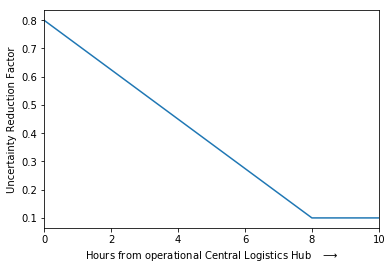

In [17]:
x=np.linspace(-1,10,100)
plt.plot(x,linear(x, 8,height=0.8,plotting=True))
plt.xlabel(r'Hours from operational Central Logistics Hub$\quad\longrightarrow$')
plt.ylabel("Uncertainty Reduction Factor")
plt.xlim((0,10))
# plt.show()
# print("make sure that all units etc. are right: km,s,hours,etc,etc")
plt.savefig("Linear_far")

#### Micromodel changing uncertainty space

In [27]:
def new_est_low_up(row, fl_n, method="linear", lin_max_dist = 8):
    """
    method: linear or sigmoid
    Verified"""
    row_label = row.name[3:]
    fl_label = "FL{}".format(fl_n)
    dist = time_matrix.loc[fl_label, row_label]
    if method == "linear":

        unc_red = linear(dist/3600, lin_max_dist, height=0.8)
#         print(unc_red)
    if method == "sigmoid":

        unc_red == sigmoid (dist/3600)
    be_new = row['best_estimate'] + (row['actual']-row['best_estimate'])* unc_red
    low_new = be_new - 0.5 * (row['upper']-row['lower']) * (1-unc_red)
    up_new = be_new + 0.5 * (row['upper']-row['lower']) * (1-unc_red)
    return low_new, be_new, up_new

In [28]:
def change_decision_based_uncertainty(df, fls_dict):
    """
    input: current df, integer operational FLs
    returns changed dataframe
    """ 
    fls = [int(key[3:]) for key,val in fls_dict.items() if val == 1]
    
    df2 = df.copy(deep=True)
    for fl in fls:
        print(fl,type(fl))
        df2['lower'], df2['best_estimate'], df2['upper'] = zip(
            *df2.apply(lambda row: new_est_low_up(row, fl), axis=1))
    return df2


# df3 = change_decision_based_uncertainty(df_test, [2, 3])

In [42]:
periods = 4  # 1 location per period -> locations = periods

global_node_counter = 0

start_situation = {key: 0 for key in FLs.Name}
global_policy_tree = {start_label: start_situation}
global_label_tree = {
    "p{}".format(p, global_node_counter): []
    if p != 0 else ["{}".format(start_label)]
    for p in range(periods + 1)
}

EMA_model_dict = {}  # XX somewhere else: global
print("starting label:", start_label)
time_start = time.time()
print("starting time:",time_start)

for p in range(periods):
    for node_i, node in enumerate(list(global_label_tree["p{}".format(p)])):
        #         print("|", p, node)
        if p < periods:
            print("Do mordm, in period:", p, "label:", node, "policy:",
                  global_policy_tree[node])
            #             new_pols = ["a", "b", "c"]
            new_pols = MORDM(
                current=global_policy_tree[node],
                n_scenarios=500,
                trace_label=node,
                table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
                saving_dir="{}/{}/".format(case, output_folder))
            for new_pol in new_pols:
                # Create new label
                global_node_counter += 1
                new_label = node + "p{}n{}".format(p + 1, global_node_counter)
                print("result:|||", new_label)
                # Create new branch
                global_label_tree["p{}".format(p + 1)].append(new_label)
                # add new policy
                global_policy_tree[new_label] = new_pol
                # change information based on policy
                #TODO not implemented yet
                #                 global_dfs_var_unc_data[new_label] = global_dfs_var_unc_data[start_label]
                print(new_pol)
                #change uncertainty based on new policy implementations
                global_dfs_var_unc_data[
                    new_label] = change_decision_based_uncertainty(
                        global_dfs_var_unc_data[node], new_pol)

        else:
            print(p, "if you see this, sth went wrong.")

            

time_end = time.time()
print("Ending_time:",time_end)
print("Total seconds:",time_end - time_start)

starting label: p0n0
starting time: 1532693883.1631193
Do mordm, in period: 0 label: p0n0 policy: {'FLO0': 0, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, 'FLO4': 0, 'FLO5': 0, 'FLO6': 0, 'FLO7': 0, 'FLO8': 0, 'FLO9': 0, 'FLO10': 0, 'FLO11': 0, 'FLO12': 0, 'FLO13': 0, 'FLO14': 0, 'FLO15': 0, 'FLO16': 0, 'FLO17': 0, 'FLO18': 0, 'FLO19': 0}


[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:62.70966172218323 
 time per run = 0.015677415430545807


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0.tar.gz


result:||| p0n0p1n1
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
result:||| p0n0p1n2
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
result:||| p0n0p1n3
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
11 <class 'int'>
result:||| p0n0p1n4
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:64.84488224983215 
 time per run = 0.016211220562458037


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1.tar.gz


result:||| p0n0p1n1p2n7
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
result:||| p0n0p1n1p2n8
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
result:||| p0n0p1n1p2n9
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:51.25444221496582 
 time per run = 0.017084814071655272


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2.tar.gz


result:||| p0n0p1n2p2n15
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
result:||| p0n0p1n2p2n16
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
result:||| p0n0p1n2p2n17
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
15 <class 'int'>
result:||| p0n0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:50.99711203575134 
 time per run = 0.016999037345250448


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3.tar.gz


result:||| p0n0p1n3p2n19
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n20
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
11 <class 'int'>
result:||| p0

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:112.58044624328613 
 time per run = 0.028145111560821532


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4.tar.gz


result:||| p0n0p1n4p2n25
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
13 <class 'int'>
result:||| p0

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:73.4420554637909 
 time per run = 0.01836051386594772


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5.tar.gz


result:||| p0n0p1n5p2n32
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
14 <class 'int'>
result:||| p0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:27.52122735977173 
 time per run = 0.011008490943908692


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6.tar.gz


result:||| p0n0p1n6p2n40
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
12 <class 'int'>
19 <class 'int'>
result:||| 

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:43.28122663497925 
 time per run = 0.010820306658744812


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n7.tar.gz


result:||| p0n0p1n1p2n7p3n45
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
result:||| p0n0p1n1p2n7p3n46
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
result:||| p0n0p1n1p2n7p3n47
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <c

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:44.78636026382446 
 time per run = 0.012796102932521276


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n8.tar.gz


result:||| p0n0p1n1p2n8p3n53
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
result:||| p0n0p1n1p2n8p3n54
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
result:||| p0n0p1n1p2n8p3n55
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <c

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.45178174972534 
 time per run = 0.012150593916575114


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n9.tar.gz


result:||| p0n0p1n1p2n9p3n60
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n9p3n61
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n9p3n62
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:40.09398651123047 
 time per run = 0.01145542471749442


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n10.tar.gz


result:||| p0n0p1n1p2n10p3n66
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n10p3n67
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n10p3n68
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:43.961838483810425 
 time per run = 0.010990459620952606


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n11.tar.gz


result:||| p0n0p1n1p2n11p3n72
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n73
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n74
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:53.07050633430481 
 time per run = 0.011793445852067735


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n12.tar.gz


result:||| p0n0p1n1p2n12p3n80
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n81
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n82
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.87317895889282 
 time per run = 0.011392336845397949


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n13.tar.gz


result:||| p0n0p1n1p2n13p3n89
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n90
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n91
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:36.93186044692993 
 time per run = 0.010551960127694266


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n14.tar.gz


result:||| p0n0p1n1p2n14p3n96
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n97
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n98
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:41.93271207809448 
 time per run = 0.011980774879455567


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n15.tar.gz


result:||| p0n0p1n2p2n15p3n103
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
result:||| p0n0p1n2p2n15p3n104
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
result:||| p0n0p1n2p2n15p3n105
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:27.05551266670227 
 time per run = 0.010822205066680909


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n16.tar.gz


result:||| p0n0p1n2p2n16p3n110
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
result:||| p0n0p1n2p2n16p3n111
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n2p2n16p3n112
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.57607650756836 
 time per run = 0.01128803825378418


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n17.tar.gz


result:||| p0n0p1n2p2n17p3n115
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n17p3n116
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n17p3n117
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.39480519294739 
 time per run = 0.011131601730982462


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n18.tar.gz


result:||| p0n0p1n2p2n18p3n119
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n120
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n121
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.716275691986084 
 time per run = 0.010905425230662028


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n19.tar.gz


result:||| p0n0p1n3p2n19p3n124
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19p3n125
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19p3n126
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:26.133805513381958 
 time per run = 0.013066902756690979


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n20.tar.gz


result:||| p0n0p1n3p2n20p3n130
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n20p3n131
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n20p3n132
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.20828342437744 
 time per run = 0.011683313369750977


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n21.tar.gz


result:||| p0n0p1n3p2n21p3n134
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n135
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n136
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:31.638880491256714 
 time per run = 0.012655552196502686


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n22.tar.gz


result:||| p0n0p1n3p2n22p3n139
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n22p3n140
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n22p3n141
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.09934973716736 
 time per run = 0.01104967486858368


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n23.tar.gz


result:||| p0n0p1n3p2n23p3n143
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n23p3n144
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n23p3n145
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.10135269165039 
 time per run = 0.011050676345825195


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n24.tar.gz


result:||| p0n0p1n3p2n24p3n147
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n148
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n149
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:46.6882746219635 
 time per run = 0.011672068655490876


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n25.tar.gz


result:||| p0n0p1n4p2n25p3n151
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n152
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n153
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


 2 label: p0n0p1n4p2n26 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:32.909457206726074 
 time per run = 0.010969819068908692


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n26.tar.gz


result:||| p0n0p1n4p2n26p3n159
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n160
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n161
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:27.483269214630127 
 time per run = 0.010993307685852051


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n27.tar.gz


result:||| p0n0p1n4p2n27p3n164
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n165
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n166
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.34448528289795 
 time per run = 0.010781495094299317


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n28.tar.gz


result:||| p0n0p1n4p2n28p3n168
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n169
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n170
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.216017723083496 
 time per run = 0.010738672574361166


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n29.tar.gz


result:||| p0n0p1n4p2n29p3n173
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n174
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n175
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.59434103965759 
 time per run = 0.01086478034655253


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n30.tar.gz


result:||| p0n0p1n4p2n30p3n179
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n30p3n180
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n30p3n181
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.309086322784424 
 time per run = 0.01076969544092814


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n31.tar.gz


result:||| p0n0p1n4p2n31p3n184
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n185
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n186
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 9 policies * 1 model(s) = 4500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4050 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] experiments finished


Total time:48.64738464355469 
 time per run = 0.01081052992078993


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n32.tar.gz


result:||| p0n0p1n5p2n32p3n190
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n191
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n192
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:42.93679928779602 
 time per run = 0.010734199821949005


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n33.tar.gz


result:||| p0n0p1n5p2n33p3n199
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n200
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n201
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:37.627832651138306 
 time per run = 0.010750809328896658


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n34.tar.gz


result:||| p0n0p1n5p2n34p3n207
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n208
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n209
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.63032555580139 
 time per run = 0.01087677518526713


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n35.tar.gz


result:||| p0n0p1n5p2n35p3n214
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n215
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n216
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:37.59847950935364 
 time per run = 0.010742422716958182


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n36.tar.gz


result:||| p0n0p1n5p2n36p3n220
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n221
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n222
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:42.64173769950867 
 time per run = 0.010660434424877166


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n37.tar.gz


result:||| p0n0p1n5p2n37p3n226
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n227
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n228
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:37.7933132648468 
 time per run = 0.010798089504241944


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n38.tar.gz


result:||| p0n0p1n5p2n38p3n234
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n235
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n236
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:37.79910326004028 
 time per run = 0.010799743788582937


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n39.tar.gz


result:||| p0n0p1n5p2n39p3n241
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n242
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n243
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:37.87032461166382 
 time per run = 0.010820092746189662


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n40.tar.gz


result:||| p0n0p1n6p2n40p3n248
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n249
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n250
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:21.911457300186157 
 time per run = 0.010955728650093078


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n41.tar.gz


result:||| p0n0p1n6p2n41p3n255
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n256
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n257
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:26.89360475540161 
 time per run = 0.010757441902160644


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n42.tar.gz


result:||| p0n0p1n6p2n42p3n259
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n260
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n261
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:31.996292114257812 
 time per run = 0.010665430704752604


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n43.tar.gz


result:||| p0n0p1n6p2n43p3n263
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n264
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n265
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:37.18460035324097 
 time per run = 0.01062417152949742


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n44.tar.gz


result:||| p0n0p1n6p2n44p3n269
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n270
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n271
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.28947710990906 
 time per run = 0.010763159036636353


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n7p3n45.tar.gz


result:||| p0n0p1n1p2n7p3n45p4n276
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
result:||| p0n0p1n1p2n7p3n45p4n277
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n7p3n45p4n278
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:26.517163038253784 
 time per run = 0.010606865215301515


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n7p3n46.tar.gz


result:||| p0n0p1n1p2n7p3n46p4n282
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
result:||| p0n0p1n1p2n7p3n46p4n283
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n7p3n46p4n284
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:21.734556436538696 
 time per run = 0.010867278218269348


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n7p3n47.tar.gz


result:||| p0n0p1n1p2n7p3n47p4n287
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n7p3n47p4n288
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n7p3n47p4n289
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16'

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:26.876367568969727 
 time per run = 0.010750547027587891


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n7p3n48.tar.gz


result:||| p0n0p1n1p2n7p3n48p4n291
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n7p3n48p4n292
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n7p3n48p4n293
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16'

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.103755712509155 
 time per run = 0.010701251904169718


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n7p3n49.tar.gz


result:||| p0n0p1n1p2n7p3n49p4n296
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n7p3n49p4n297
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n7p3n49p4n298
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16'

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:37.15673327445984 
 time per run = 0.010616209506988526


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n7p3n50.tar.gz


result:||| p0n0p1n1p2n7p3n50p4n302
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n7p3n50p4n303
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n7p3n50p4n304
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:31.619811058044434 
 time per run = 0.010539937019348144


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n7p3n51.tar.gz


result:||| p0n0p1n1p2n7p3n51p4n309
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n7p3n51p4n310
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n7p3n51p4n311
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.09550404548645 
 time per run = 0.010698501348495483


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n7p3n52.tar.gz


result:||| p0n0p1n1p2n7p3n52p4n315
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n7p3n52p4n316
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n7p3n52p4n317
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.18700337409973 
 time per run = 0.011062334458033243


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n8p3n53.tar.gz


result:||| p0n0p1n1p2n8p3n53p4n321
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
result:||| p0n0p1n1p2n8p3n53p4n322
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n8p3n53p4n323
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.65755605697632 
 time per run = 0.010885852018992106


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n8p3n54.tar.gz


result:||| p0n0p1n1p2n8p3n54p4n327
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
result:||| p0n0p1n1p2n8p3n54p4n328
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n8p3n54p4n329
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:26.455121517181396 
 time per run = 0.01058204860687256


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n8p3n55.tar.gz


result:||| p0n0p1n1p2n8p3n55p4n333
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n8p3n55p4n334
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n8p3n55p4n335
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16'

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:26.837639808654785 
 time per run = 0.010735055923461915


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n8p3n56.tar.gz


result:||| p0n0p1n1p2n8p3n56p4n338
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n8p3n56p4n339
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n8p3n56p4n340
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16':

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:37.09040546417236 
 time per run = 0.010597258704049246


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n8p3n57.tar.gz


result:||| p0n0p1n1p2n8p3n57p4n343
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n8p3n57p4n344
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n8p3n57p4n345
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16':

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:26.994549989700317 
 time per run = 0.010797819995880127


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n8p3n58.tar.gz


result:||| p0n0p1n1p2n8p3n58p4n350
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n8p3n58p4n351
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n8p3n58p4n352
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16':

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.89017343521118 
 time per run = 0.010963391145070394


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n8p3n59.tar.gz


result:||| p0n0p1n1p2n8p3n59p4n355
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n8p3n59p4n356
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n8p3n59p4n357
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16':

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:21.635616779327393 
 time per run = 0.010817808389663697


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n9p3n60.tar.gz


result:||| p0n0p1n1p2n9p3n60p4n361
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n9p3n60p4n362
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n9p3n60p4n363
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16'

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:27.50040316581726 
 time per run = 0.011000161266326905


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n9p3n61.tar.gz


result:||| p0n0p1n1p2n9p3n61p4n365
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n9p3n61p4n366
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n9p3n61p4n367
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16':

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:26.39772891998291 
 time per run = 0.010559091567993164


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n9p3n62.tar.gz


result:||| p0n0p1n1p2n9p3n62p4n370
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n9p3n62p4n371
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n1p2n9p3n62p4n372
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16':

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:21.95639157295227 
 time per run = 0.010978195786476136


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n9p3n63.tar.gz


result:||| p0n0p1n1p2n9p3n63p4n375
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n9p3n63p4n376
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n9p3n63p4n377
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:31.360050201416016 
 time per run = 0.010453350067138672


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n9p3n64.tar.gz


result:||| p0n0p1n1p2n9p3n64p4n379
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n9p3n64p4n380
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n9p3n64p4n381
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:21.59496760368347 
 time per run = 0.010797483801841735


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n9p3n65.tar.gz


result:||| p0n0p1n1p2n9p3n65p4n385
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n9p3n65p4n386
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n9p3n65p4n387
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:26.54166841506958 
 time per run = 0.010616667366027833


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n10p3n66.tar.gz


result:||| p0n0p1n1p2n10p3n66p4n389
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n10p3n66p4n390
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n10p3n66p4n391
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:26.732051372528076 
 time per run = 0.010692820549011231


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n10p3n67.tar.gz


result:||| p0n0p1n1p2n10p3n67p4n394
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n10p3n67p4n395
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n10p3n67p4n396
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:21.156697511672974 
 time per run = 0.010578348755836487


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n10p3n68.tar.gz


result:||| p0n0p1n1p2n10p3n68p4n399
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n10p3n68p4n400
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n1p2n10p3n68p4n401
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:31.635952472686768 
 time per run = 0.01054531749089559


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n10p3n69.tar.gz


result:||| p0n0p1n1p2n10p3n69p4n403
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n10p3n69p4n404
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n10p3n69p4n405
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:31.797799348831177 
 time per run = 0.010599266449610392


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n10p3n70.tar.gz


result:||| p0n0p1n1p2n10p3n70p4n409
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n10p3n70p4n410
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n10p3n70p4n411
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:26.401245832443237 
 time per run = 0.010560498332977295


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n10p3n71.tar.gz


result:||| p0n0p1n1p2n10p3n71p4n415
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n10p3n71p4n416
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n10p3n71p4n417
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:31.55993413925171 
 time per run = 0.010519978046417236


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n11p3n72.tar.gz


result:||| p0n0p1n1p2n11p3n72p4n420
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n72p4n421
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n72p4n422
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Do mordm, in period: 3 label: p0n0p1n1p2n11p3n73 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:27.54521608352661 
 time per run = 0.011018086433410644


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n11p3n73.tar.gz


result:||| p0n0p1n1p2n11p3n73p4n426
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n73p4n427
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n73p4n428
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:36.91586923599243 
 time per run = 0.010547391210283552


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n11p3n74.tar.gz


result:||| p0n0p1n1p2n11p3n74p4n431
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n74p4n432
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n74p4n433
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:31.97569513320923 
 time per run = 0.010658565044403077


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n11p3n75.tar.gz


result:||| p0n0p1n1p2n11p3n75p4n438
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n75p4n439
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n75p4n440
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:31.742828845977783 
 time per run = 0.010580942948659262


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n11p3n76.tar.gz


result:||| p0n0p1n1p2n11p3n76p4n444
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n76p4n445
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n11p3n76p4n446
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:46.523369789123535 
 time per run = 0.011630842447280883


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n11p3n77.tar.gz


result:||| p0n0p1n1p2n11p3n77p4n450
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n11p3n77p4n451
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n11p3n77p4n452
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.899884462356567 
 time per run = 0.011959953784942627


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n11p3n78.tar.gz


result:||| p0n0p1n1p2n11p3n78p4n458
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n11p3n78p4n459
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n11p3n78p4n460
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.59333300590515 
 time per run = 0.011531111001968384


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n11p3n79.tar.gz


result:||| p0n0p1n1p2n11p3n79p4n463
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n11p3n79p4n464
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n11p3n79p4n465
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:54.943548917770386 
 time per run = 0.015698156833648683


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n12p3n80.tar.gz


result:||| p0n0p1n1p2n12p3n80p4n469
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n80p4n470
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n80p4n471
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:79.17427206039429 
 time per run = 0.02262122058868408


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n12p3n81.tar.gz


result:||| p0n0p1n1p2n12p3n81p4n476
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n81p4n477
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n81p4n478
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.95825552940369 
 time per run = 0.012986085176467895


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n12p3n82.tar.gz


result:||| p0n0p1n1p2n12p3n82p4n483
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n82p4n484
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n82p4n485
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.92043972015381 
 time per run = 0.011973479906717936


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n12p3n83.tar.gz


result:||| p0n0p1n1p2n12p3n83p4n489
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n83p4n490
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n83p4n491
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:42.809494495391846 
 time per run = 0.014269831498463949


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n12p3n84.tar.gz


result:||| p0n0p1n1p2n12p3n84p4n495
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n84p4n496
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n84p4n497
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:62.83761644363403 
 time per run = 0.015709404110908508


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n12p3n85.tar.gz


result:||| p0n0p1n1p2n12p3n85p4n501
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n85p4n502
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n1p2n12p3n85p4n503
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:38.526947021484375 
 time per run = 0.011007699148995536


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n12p3n86.tar.gz


result:||| p0n0p1n1p2n12p3n86p4n509
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n12p3n86p4n510
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n12p3n86p4n511
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:43.56006622314453 
 time per run = 0.010890016555786133


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n12p3n87.tar.gz


result:||| p0n0p1n1p2n12p3n87p4n516
{'FLO0': 0.0, 'FLO1': 1.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
1 <class 'int'>
3 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n12p3n87p4n517
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n1p2n12p3n87p4n518
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.13792657852173 
 time per run = 0.010712642192840576


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n12p3n88.tar.gz


result:||| p0n0p1n1p2n12p3n88p4n524
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n12p3n88p4n525
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n12p3n88p4n526
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.34748435020447 
 time per run = 0.01078249478340149


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n13p3n89.tar.gz


result:||| p0n0p1n1p2n13p3n89p4n530
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n89p4n531
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n89p4n532
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Do mordm, in period: 3 label: p0n0p1n1p2n13p3n90 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:27.488266229629517 
 time per run = 0.010995306491851807


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n13p3n90.tar.gz


result:||| p0n0p1n1p2n13p3n90p4n536
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n90p4n537
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n90p4n538
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:31.942715167999268 
 time per run = 0.010647571722666423


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n13p3n91.tar.gz


result:||| p0n0p1n1p2n13p3n91p4n541
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n91p4n542
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n91p4n543
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:35.536725759506226 
 time per run = 0.01421469030380249


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n13p3n92.tar.gz


result:||| p0n0p1n1p2n13p3n92p4n547
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n92p4n548
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n92p4n549
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:27.612868785858154 
 time per run = 0.011045147514343262


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n13p3n93.tar.gz


result:||| p0n0p1n1p2n13p3n93p4n552
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n93p4n553
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n93p4n554
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:37.780481815338135 
 time per run = 0.010794423375810895


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n13p3n94.tar.gz


result:||| p0n0p1n1p2n13p3n94p4n557
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n94p4n558
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n1p2n13p3n94p4n559
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:37.85033345222473 
 time per run = 0.012616777817408244


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n13p3n95.tar.gz


result:||| p0n0p1n1p2n13p3n95p4n564
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n13p3n95p4n565
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n13p3n95p4n566
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:48.13627648353577 
 time per run = 0.016045425494511923


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n14p3n96.tar.gz


result:||| p0n0p1n1p2n14p3n96p4n570
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n96p4n571
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n96p4n572
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:42.231510639190674 
 time per run = 0.01689260425567627


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n14p3n97.tar.gz


result:||| p0n0p1n1p2n14p3n97p4n576
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n97p4n577
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n97p4n578
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:30.481577157974243 
 time per run = 0.015240788578987122


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n14p3n98.tar.gz


result:||| p0n0p1n1p2n14p3n98p4n581
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n98p4n582
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n98p4n583
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:27.12647247314453 
 time per run = 0.010850588989257812


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n14p3n99.tar.gz


result:||| p0n0p1n1p2n14p3n99p4n585
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n99p4n586
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n99p4n587
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.51538681983948 
 time per run = 0.010838462273279826


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n14p3n100.tar.gz


result:||| p0n0p1n1p2n14p3n100p4n590
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n100p4n591
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n100p4n592
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n1p2n14p3n101 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
Total time:32.18457770347595 
 time per run = 0.010728192567825317


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n14p3n101.tar.gz


result:||| p0n0p1n1p2n14p3n101p4n596
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n101p4n597
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n101p4n598
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.29151654243469 
 time per run = 0.010763838847478231


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n1p2n14p3n102.tar.gz


result:||| p0n0p1n1p2n14p3n102p4n602
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n102p4n603
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n1p2n14p3n102p4n604
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.56815147399902 
 time per run = 0.011189383824666341


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n15p3n103.tar.gz


result:||| p0n0p1n2p2n15p3n103p4n608
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
result:||| p0n0p1n2p2n15p3n103p4n609
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n2p2n15p3n103p4n610
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


 3 label: p0n0p1n2p2n15p3n104 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:33.57583808898926 
 time per run = 0.011191946029663086


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n15p3n104.tar.gz


result:||| p0n0p1n2p2n15p3n104p4n614
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
result:||| p0n0p1n2p2n15p3n104p4n615
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n2p2n15p3n104p4n616
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:30.3001229763031 
 time per run = 0.01212004919052124


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n15p3n105.tar.gz


result:||| p0n0p1n2p2n15p3n105p4n619
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n2p2n15p3n105p4n620
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n2p2n15p3n105p4n621
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:32.495641469955444 
 time per run = 0.012998256587982178


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n15p3n106.tar.gz


result:||| p0n0p1n2p2n15p3n106p4n624
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n2p2n15p3n106p4n625
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n2p2n15p3n106p4n626
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:37.96829056739807 
 time per run = 0.010848083019256593


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n15p3n107.tar.gz


result:||| p0n0p1n2p2n15p3n107p4n629
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n2p2n15p3n107p4n630
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n2p2n15p3n107p4n631
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:33.96655607223511 
 time per run = 0.013586622428894043


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n15p3n108.tar.gz


result:||| p0n0p1n2p2n15p3n108p4n636
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n15p3n108p4n637
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n15p3n108p4n638
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'F

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:31.95470666885376 
 time per run = 0.01065156888961792


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n15p3n109.tar.gz


result:||| p0n0p1n2p2n15p3n109p4n641
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n15p3n109p4n642
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n15p3n109p4n643
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


 3 label: p0n0p1n2p2n16p3n110 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
Total time:40.46175456047058 
 time per run = 0.01348725152015686


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n16p3n110.tar.gz


result:||| p0n0p1n2p2n16p3n110p4n647
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
result:||| p0n0p1n2p2n16p3n110p4n648
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n2p2n16p3n110p4n649
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:47.01208806037903 
 time per run = 0.018804835224151613


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n16p3n111.tar.gz


result:||| p0n0p1n2p2n16p3n111p4n653
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n2p2n16p3n111p4n654
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n2p2n16p3n111p4n655
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:39.74567270278931 
 time per run = 0.019872836351394654


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n16p3n112.tar.gz


result:||| p0n0p1n2p2n16p3n112p4n656
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n2p2n16p3n112p4n657
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n2p2n16p3n112p4n658
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.876953840255737 
 time per run = 0.019917969226837157


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n16p3n113.tar.gz


result:||| p0n0p1n2p2n16p3n113p4n660
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n16p3n113p4n661
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n16p3n113p4n662
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, '

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:55.24837517738342 
 time per run = 0.01841612505912781


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n16p3n114.tar.gz


result:||| p0n0p1n2p2n16p3n114p4n663
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n16p3n114p4n664
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n16p3n114p4n665
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:45.39701533317566 
 time per run = 0.018158806133270262


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n17p3n115.tar.gz


result:||| p0n0p1n2p2n17p3n115p4n668
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n17p3n115p4n669
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n17p3n115p4n670
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'F

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:27.231411933898926 
 time per run = 0.018154274622599283


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n17p3n116.tar.gz


result:||| p0n0p1n2p2n17p3n116p4n673
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n17p3n116p4n674
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n17p3n116p4n675
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, '

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.09291100502014 
 time per run = 0.01754645550251007


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n17p3n117.tar.gz


result:||| p0n0p1n2p2n17p3n117p4n676
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n17p3n117p4n677
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n2p2n17p3n117p4n678
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.65479373931885 
 time per run = 0.016827396869659422


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n17p3n118.tar.gz


result:||| p0n0p1n2p2n17p3n118p4n679
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n17p3n118p4n680
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
8 <class 'int'>
9 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n17p3n118p4n681
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.43518686294556 
 time per run = 0.010811728954315186


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n18p3n119.tar.gz


result:||| p0n0p1n2p2n18p3n119p4n683
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n119p4n684
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n119p4n685
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.0343976020813 
 time per run = 0.01101719880104065


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n18p3n120.tar.gz


result:||| p0n0p1n2p2n18p3n120p4n689
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n120p4n690
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n120p4n691
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:26.809934854507446 
 time per run = 0.010723973941802979


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n18p3n121.tar.gz


result:||| p0n0p1n2p2n18p3n121p4n693
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n121p4n694
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n121p4n695
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:26.034101486206055 
 time per run = 0.013017050743103028


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n18p3n122.tar.gz


result:||| p0n0p1n2p2n18p3n122p4n696
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n122p4n697
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n122p4n698
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.37989020347595 
 time per run = 0.011126630067825317


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n2p2n18p3n123.tar.gz


result:||| p0n0p1n2p2n18p3n123p4n700
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n123p4n701
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n2p2n18p3n123p4n702
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.37019681930542 
 time per run = 0.01118509840965271


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n19p3n124.tar.gz


result:||| p0n0p1n3p2n19p3n124p4n706
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19p3n124p4n707
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n19p3n124p4n708
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:27.22626805305481 
 time per run = 0.010890507221221923


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n19p3n125.tar.gz


result:||| p0n0p1n3p2n19p3n125p4n710
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19p3n125p4n711
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19p3n125p4n712
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:27.07736372947693 
 time per run = 0.010830945491790771


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n19p3n126.tar.gz


result:||| p0n0p1n3p2n19p3n126p4n715
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19p3n126p4n716
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n19p3n126p4n717
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:21.814706087112427 
 time per run = 0.010907353043556214


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n19p3n127.tar.gz


result:||| p0n0p1n3p2n19p3n127p4n720
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n19p3n127p4n721
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n19p3n127p4n722
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.845218658447266 
 time per run = 0.010948406219482423


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n19p3n128.tar.gz


result:||| p0n0p1n3p2n19p3n128p4n724
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n3p2n19p3n128p4n725
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n3p2n19p3n128p4n726
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:24.0592303276062 
 time per run = 0.0120296151638031


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n19p3n129.tar.gz


result:||| p0n0p1n3p2n19p3n129p4n730
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n19p3n129p4n731
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n19p3n129p4n732
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:21.689586877822876 
 time per run = 0.010844793438911439


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n20p3n130.tar.gz


result:||| p0n0p1n3p2n20p3n130p4n734
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n20p3n130p4n735
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n20p3n130p4n736
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:16.38862180709839 
 time per run = 0.010925747871398927


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n20p3n131.tar.gz


result:||| p0n0p1n3p2n20p3n131p4n738
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n20p3n131p4n739
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n3p2n20p3n132 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14':

[MainProcess/INFO] performing 500 scenarios * 2 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


Total time:11.210871934890747 
 time per run = 0.011210871934890747


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n20p3n132.tar.gz


result:||| p0n0p1n3p2n20p3n132p4n740
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n20p3n132p4n741
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n3p2n20p3n133 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:21.472710371017456 
 time per run = 0.010736355185508728


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n20p3n133.tar.gz


result:||| p0n0p1n3p2n20p3n133p4n742
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n20p3n133p4n743
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n20p3n133p4n744
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:26.894685745239258 
 time per run = 0.010757874298095703


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n21p3n134.tar.gz


result:||| p0n0p1n3p2n21p3n134p4n746
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n134p4n747
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n134p4n748
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.478134155273438 
 time per run = 0.011239067077636718


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n21p3n135.tar.gz


result:||| p0n0p1n3p2n21p3n135p4n751
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n135p4n752
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n135p4n753
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.927302837371826 
 time per run = 0.011963651418685913


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n21p3n136.tar.gz


result:||| p0n0p1n3p2n21p3n136p4n755
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n136p4n756
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n21p3n136p4n757
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:20.20643424987793 
 time per run = 0.013470956166585286


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n21p3n137.tar.gz


result:||| p0n0p1n3p2n21p3n137p4n758
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n21p3n137p4n759
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n21p3n137p4n760
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:30.957909107208252 
 time per run = 0.012383163642883301


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n21p3n138.tar.gz


result:||| p0n0p1n3p2n21p3n138p4n761
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n21p3n138p4n762
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n21p3n138p4n763
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.441717386245728 
 time per run = 0.011776686954498291


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n22p3n139.tar.gz


result:||| p0n0p1n3p2n22p3n139p4n766
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n22p3n139p4n767
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n22p3n139p4n768
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:16.40370750427246 
 time per run = 0.010935805002848306


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n22p3n140.tar.gz


result:||| p0n0p1n3p2n22p3n140p4n771
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n22p3n140p4n772
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n3p2n22p3n141 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14':

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.360945463180542 
 time per run = 0.011680472731590272


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n22p3n141.tar.gz


result:||| p0n0p1n3p2n22p3n141p4n773
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n22p3n141p4n774
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
result:||| p0n0p1n3p2n22p3n141p4n775
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:17.48399305343628 
 time per run = 0.01165599536895752


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n22p3n142.tar.gz


result:||| p0n0p1n3p2n22p3n142p4n776
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n22p3n142p4n777
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n3p2n23p3n143 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14'

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:21.684589385986328 
 time per run = 0.010842294692993163


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n23p3n143.tar.gz


result:||| p0n0p1n3p2n23p3n143p4n778
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n23p3n143p4n779
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n23p3n143p4n780
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 2 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


Total time:11.025456428527832 
 time per run = 0.011025456428527832


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n23p3n144.tar.gz


result:||| p0n0p1n3p2n23p3n144p4n782
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n23p3n144p4n783
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n3p2n23p3n145 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:16.655466318130493 
 time per run = 0.011103644212086995


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n23p3n145.tar.gz


result:||| p0n0p1n3p2n23p3n145p4n784
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n23p3n145p4n785
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
result:||| p0n0p1n3p2n23p3n145p4n786
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 2 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


Total time:11.16760802268982 
 time per run = 0.01116760802268982


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n23p3n146.tar.gz


result:||| p0n0p1n3p2n23p3n146p4n787
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n23p3n146p4n788
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n3p2n24p3n147 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:21.426536083221436 
 time per run = 0.010713268041610718


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n24p3n147.tar.gz


result:||| p0n0p1n3p2n24p3n147p4n789
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n147p4n790
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n147p4n791
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.130329370498657 
 time per run = 0.011065164685249328


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n24p3n148.tar.gz


result:||| p0n0p1n3p2n24p3n148p4n793
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n148p4n794
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n148p4n795
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:16.571515321731567 
 time per run = 0.011047676881154378


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n24p3n149.tar.gz


result:||| p0n0p1n3p2n24p3n149p4n797
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n149p4n798
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n3p2n24p3n150 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14'

[MainProcess/INFO] performing 500 scenarios * 2 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


Total time:11.178599834442139 
 time per run = 0.01117859983444214


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n3p2n24p3n150.tar.gz


result:||| p0n0p1n3p2n24p3n150p4n799
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n3p2n24p3n150p4n800
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n4p2n25p3n151 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.26127815246582 
 time per run = 0.011087092717488607


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n25p3n151.tar.gz


result:||| p0n0p1n4p2n25p3n151p4n801
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n151p4n802
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n151p4n803
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:30.689435243606567 
 time per run = 0.012275774097442627


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n25p3n152.tar.gz


result:||| p0n0p1n4p2n25p3n152p4n807
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n152p4n808
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n152p4n809
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:45.18113565444946 
 time per run = 0.012908895901271275


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n25p3n153.tar.gz


result:||| p0n0p1n4p2n25p3n153p4n812
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n153p4n813
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n153p4n814
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.995824337005615 
 time per run = 0.012331941445668538


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n25p3n154.tar.gz


result:||| p0n0p1n4p2n25p3n154p4n819
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n154p4n820
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n154p4n821
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.267093658447266 
 time per run = 0.012755697886149088


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n25p3n155.tar.gz


result:||| p0n0p1n4p2n25p3n155p4n825
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n155p4n826
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n25p3n155p4n827
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:45.944703340530396 
 time per run = 0.0114861758351326


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n25p3n156.tar.gz


result:||| p0n0p1n4p2n25p3n156p4n831
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n4p2n25p3n156p4n832
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n4p2n25p3n156p4n833
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:31.203137159347534 
 time per run = 0.012481254863739013


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n25p3n157.tar.gz


result:||| p0n0p1n4p2n25p3n157p4n839
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n4p2n25p3n157p4n840
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n4p2n25p3n157p4n841
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.32626008987427 
 time per run = 0.012108753363291423


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n25p3n158.tar.gz


result:||| p0n0p1n4p2n25p3n158p4n844
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n25p3n158p4n845
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n25p3n158p4n846
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.43932557106018 
 time per run = 0.011479775190353394


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n26p3n159.tar.gz


result:||| p0n0p1n4p2n26p3n159p4n850
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n159p4n851
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n159p4n852
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, '

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.8938889503479 
 time per run = 0.01195755558013916


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n26p3n160.tar.gz


result:||| p0n0p1n4p2n26p3n160p4n856
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n160p4n857
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n4p2n26p3n161 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14':

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:25.58258318901062 
 time per run = 0.01279129159450531


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n26p3n161.tar.gz


result:||| p0n0p1n4p2n26p3n161p4n858
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n161p4n859
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n161p4n860
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.160492420196533 
 time per run = 0.011080246210098267


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n26p3n162.tar.gz


result:||| p0n0p1n4p2n26p3n162p4n862
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n26p3n162p4n863
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n4p2n26p3n163 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:33.23699426651001 
 time per run = 0.013294797706604003


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n26p3n163.tar.gz


result:||| p0n0p1n4p2n26p3n163p4n864
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n26p3n163p4n865
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n26p3n163p4n866
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.647460222244263 
 time per run = 0.011858984088897705


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n27p3n164.tar.gz


result:||| p0n0p1n4p2n27p3n164p4n869
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n164p4n870
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n164p4n871
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:24.479989528656006 
 time per run = 0.012239994764328002


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n27p3n165.tar.gz


result:||| p0n0p1n4p2n27p3n165p4n874
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n165p4n875
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n165p4n876
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:24.405030250549316 
 time per run = 0.012202515125274658


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n27p3n166.tar.gz


result:||| p0n0p1n4p2n27p3n166p4n878
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n166p4n879
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n27p3n166p4n880
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.561084508895874 
 time per run = 0.011280542254447938


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n27p3n167.tar.gz


result:||| p0n0p1n4p2n27p3n167p4n881
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n27p3n167p4n882
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n27p3n167p4n883
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:42.23382568359375 
 time per run = 0.012066807338169642


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n28p3n168.tar.gz


result:||| p0n0p1n4p2n28p3n168p4n885
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n168p4n886
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n168p4n887
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:33.33991718292236 
 time per run = 0.013335966873168945


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n28p3n169.tar.gz


result:||| p0n0p1n4p2n28p3n169p4n892
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n169p4n893
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n4p2n28p3n170 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14':

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.368624687194824 
 time per run = 0.011684312343597411


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n28p3n170.tar.gz


result:||| p0n0p1n4p2n28p3n170p4n894
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n170p4n895
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n170p4n896
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.383936166763306 
 time per run = 0.011753574466705323


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n28p3n171.tar.gz


result:||| p0n0p1n4p2n28p3n171p4n897
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n171p4n898
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n28p3n171p4n899
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:37.10723567008972 
 time per run = 0.01484289426803589


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n28p3n172.tar.gz


result:||| p0n0p1n4p2n28p3n172p4n901
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n28p3n172p4n902
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n4p2n29p3n173 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14'

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.619686126708984 
 time per run = 0.010873228708902994


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n29p3n173.tar.gz


result:||| p0n0p1n4p2n29p3n173p4n903
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n173p4n904
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n173p4n905
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.033934354782104 
 time per run = 0.01751696717739105


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n29p3n174.tar.gz


result:||| p0n0p1n4p2n29p3n174p4n909
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n174p4n910
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n174p4n911
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:41.98962068557739 
 time per run = 0.016795848274230956


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n29p3n175.tar.gz


result:||| p0n0p1n4p2n29p3n175p4n913
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n175p4n914
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n175p4n915
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:36.487969398498535 
 time per run = 0.014595187759399414


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n29p3n176.tar.gz


result:||| p0n0p1n4p2n29p3n176p4n918
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n176p4n919
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n176p4n920
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:27.612842559814453 
 time per run = 0.013806421279907227


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n29p3n177.tar.gz


result:||| p0n0p1n4p2n29p3n177p4n922
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n177p4n923
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n29p3n177p4n924
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:28.16934823989868 
 time per run = 0.01408467411994934


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n29p3n178.tar.gz


result:||| p0n0p1n4p2n29p3n178p4n926
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n29p3n178p4n927
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n29p3n178p4n928
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:41.447431564331055 
 time per run = 0.013815810521443685


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n30p3n179.tar.gz


result:||| p0n0p1n4p2n30p3n179p4n930
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n30p3n179p4n931
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n30p3n179p4n932
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:27.768106937408447 
 time per run = 0.013884053468704223


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n30p3n180.tar.gz


result:||| p0n0p1n4p2n30p3n180p4n936
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n30p3n180p4n937
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n4p2n30p3n181 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:21.621623754501343 
 time per run = 0.01441441583633423


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n30p3n181.tar.gz


result:||| p0n0p1n4p2n30p3n181p4n938
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n30p3n181p4n939
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n30p3n181p4n940
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:27.84106469154358 
 time per run = 0.013920532345771789


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n30p3n182.tar.gz


result:||| p0n0p1n4p2n30p3n182p4n941
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n30p3n182p4n942
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n30p3n182p4n943
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:28.121948957443237 
 time per run = 0.014060974478721618


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n30p3n183.tar.gz


result:||| p0n0p1n4p2n30p3n183p4n945
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n30p3n183p4n946
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n4p2n31p3n184 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:48.74493384361267 
 time per run = 0.016248311281204224


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n31p3n184.tar.gz


result:||| p0n0p1n4p2n31p3n184p4n947
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n184p4n948
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n184p4n949
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:37.310606718063354 
 time per run = 0.014924242687225342


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n31p3n185.tar.gz


result:||| p0n0p1n4p2n31p3n185p4n953
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n185p4n954
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n185p4n955
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:34.98926329612732 
 time per run = 0.013995705318450928


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n31p3n186.tar.gz


result:||| p0n0p1n4p2n31p3n186p4n958
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n186p4n959
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n186p4n960
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.50670289993286 
 time per run = 0.017253351449966432


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n31p3n187.tar.gz


result:||| p0n0p1n4p2n31p3n187p4n962
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n187p4n963
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n187p4n964
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.96748161315918 
 time per run = 0.01848374080657959


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n31p3n188.tar.gz


result:||| p0n0p1n4p2n31p3n188p4n966
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n188p4n967
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n4p2n31p3n189 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.608702659606934 
 time per run = 0.018304351329803466


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n4p2n31p3n189.tar.gz


result:||| p0n0p1n4p2n31p3n189p4n968
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n189p4n969
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n4p2n31p3n189p4n970
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.52363300323486 
 time per run = 0.011292466572352819


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n32p3n190.tar.gz


result:||| p0n0p1n5p2n32p3n190p4n972
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n190p4n973
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n190p4n974
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:45.964682817459106 
 time per run = 0.01313276651927403


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n32p3n191.tar.gz


result:||| p0n0p1n5p2n32p3n191p4n979
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n191p4n980
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n191p4n981
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.182206869125366 
 time per run = 0.012727402289708456


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n32p3n192.tar.gz


result:||| p0n0p1n5p2n32p3n192p4n986
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n192p4n987
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n192p4n988
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'F

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:32.791908264160156 
 time per run = 0.010930636088053386


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n32p3n193.tar.gz


result:||| p0n0p1n5p2n32p3n193p4n992
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n193p4n993
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n193p4n994
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.776663303375244 
 time per run = 0.011258887767791747


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n32p3n194.tar.gz


result:||| p0n0p1n5p2n32p3n194p4n998
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n194p4n999
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n194p4n1000
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:44.09476137161255 
 time per run = 0.011023690342903137


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n32p3n195.tar.gz


result:||| p0n0p1n5p2n32p3n195p4n1004
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n195p4n1005
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n32p3n195p4n1006
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:42.065479040145874 
 time per run = 0.012018708297184535


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n32p3n196.tar.gz


result:||| p0n0p1n5p2n32p3n196p4n1012
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n32p3n196p4n1013
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n32p3n196p4n1014
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:50.07533550262451 
 time per run = 0.012518833875656128


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n32p3n197.tar.gz


result:||| p0n0p1n5p2n32p3n197p4n1019
{'FLO0': 0.0, 'FLO1': 1.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
1 <class 'int'>
3 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n32p3n197p4n1020
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 1.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
16 <class 'int'>
result:||| p0n0p1n5p2n32p3n197p4n1021
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.25839281082153 
 time per run = 0.011419464270273844


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n32p3n198.tar.gz


result:||| p0n0p1n5p2n32p3n198p4n1027
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n32p3n198p4n1028
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n32p3n198p4n1029
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:41.87164378166199 
 time per run = 0.011963326794760568


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n33p3n199.tar.gz


result:||| p0n0p1n5p2n33p3n199p4n1033
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n199p4n1034
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n199p4n1035
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:45.50370407104492 
 time per run = 0.015167901357014974


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n33p3n200.tar.gz


result:||| p0n0p1n5p2n33p3n200p4n1040
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n200p4n1041
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n200p4n1042
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:47.50645065307617 
 time per run = 0.01900258026123047


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n33p3n201.tar.gz


result:||| p0n0p1n5p2n33p3n201p4n1046
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n201p4n1047
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n201p4n1048
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.59668970108032 
 time per run = 0.017298344850540163


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n33p3n202.tar.gz


result:||| p0n0p1n5p2n33p3n202p4n1051
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n202p4n1052
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n202p4n1053
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:44.17510914802551 
 time per run = 0.017670043659210204


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n33p3n203.tar.gz


result:||| p0n0p1n5p2n33p3n203p4n1055
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n203p4n1056
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n203p4n1057
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:47.71333837509155 
 time per run = 0.015904446125030516


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n33p3n204.tar.gz


result:||| p0n0p1n5p2n33p3n204p4n1060
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n204p4n1061
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n33p3n204p4n1062
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:48.61222171783447 
 time per run = 0.016204073905944825


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n33p3n205.tar.gz


result:||| p0n0p1n5p2n33p3n205p4n1066
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n33p3n205p4n1067
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n33p3n205p4n1068
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:41.088480949401855 
 time per run = 0.013696160316467285


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n33p3n206.tar.gz


result:||| p0n0p1n5p2n33p3n206p4n1072
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n33p3n206p4n1073
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n33p3n206p4n1074
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:51.98440146446228 
 time per run = 0.014852686132703508


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n34p3n207.tar.gz


result:||| p0n0p1n5p2n34p3n207p4n1078
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n207p4n1079
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n207p4n1080
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:41.28149175643921 
 time per run = 0.013760497252146403


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n34p3n208.tar.gz


result:||| p0n0p1n5p2n34p3n208p4n1085
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n208p4n1086
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n208p4n1087
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:40.55610251426697 
 time per run = 0.013518700838088989


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n34p3n209.tar.gz


result:||| p0n0p1n5p2n34p3n209p4n1091
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n209p4n1092
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
9 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n209p4n1093
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:34.33319044113159 
 time per run = 0.013733276176452636


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n34p3n210.tar.gz


result:||| p0n0p1n5p2n34p3n210p4n1096
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n210p4n1097
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n210p4n1098
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:36.32873749732971 
 time per run = 0.014531494998931884


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n34p3n211.tar.gz


result:||| p0n0p1n5p2n34p3n211p4n1101
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n211p4n1102
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n34p3n211p4n1103
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:37.50736880302429 
 time per run = 0.015002947521209717


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n34p3n212.tar.gz


result:||| p0n0p1n5p2n34p3n212p4n1106
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n34p3n212p4n1107
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n34p3n212p4n1108
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:44.286293029785156 
 time per run = 0.014762097676595053


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n34p3n213.tar.gz


result:||| p0n0p1n5p2n34p3n213p4n1111
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n34p3n213p4n1112
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n34p3n213p4n1113
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:30.280664443969727 
 time per run = 0.015140332221984864


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n35p3n214.tar.gz


result:||| p0n0p1n5p2n35p3n214p4n1117
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n214p4n1118
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n214p4n1119
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:35.10728669166565 
 time per run = 0.01404291467666626


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n35p3n215.tar.gz


result:||| p0n0p1n5p2n35p3n215p4n1121
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n215p4n1122
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n215p4n1123
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:30.418591022491455 
 time per run = 0.012167436408996582


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n35p3n216.tar.gz


result:||| p0n0p1n5p2n35p3n216p4n1126
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n216p4n1127
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
9 <class 'int'>
11 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n216p4n1128
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:27.808539152145386 
 time per run = 0.013904269576072693


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n35p3n217.tar.gz


result:||| p0n0p1n5p2n35p3n217p4n1131
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n217p4n1132
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n217p4n1133
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.23146319389343 
 time per run = 0.011743821064631144


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n35p3n218.tar.gz


result:||| p0n0p1n5p2n35p3n218p4n1135
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n218p4n1136
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n35p3n218p4n1137
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:22.98620104789734 
 time per run = 0.01149310052394867


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n35p3n219.tar.gz


result:||| p0n0p1n5p2n35p3n219p4n1141
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n35p3n219p4n1142
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
9 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n35p3n219p4n1143
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:34.53023314476013 
 time per run = 0.011510077714920044


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n36p3n220.tar.gz


result:||| p0n0p1n5p2n36p3n220p4n1145
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n220p4n1146
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n220p4n1147
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:28.83249807357788 
 time per run = 0.011532999229431152


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n36p3n221.tar.gz


result:||| p0n0p1n5p2n36p3n221p4n1151
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n221p4n1152
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n221p4n1153
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:27.95899510383606 
 time per run = 0.011183598041534425


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n36p3n222.tar.gz


result:||| p0n0p1n5p2n36p3n222p4n1156
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n222p4n1157
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n222p4n1158
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:23.54752206802368 
 time per run = 0.01177376103401184


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n36p3n223.tar.gz


result:||| p0n0p1n5p2n36p3n223p4n1161
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n223p4n1162
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
11 <class 'int'>
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n223p4n1163
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.49045705795288 
 time per run = 0.011163485685984294


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n36p3n224.tar.gz


result:||| p0n0p1n5p2n36p3n224p4n1165
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n224p4n1166
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n36p3n224p4n1167
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


 3 label: p0n0p1n5p2n36p3n225 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
Total time:27.775578260421753 
 time per run = 0.0111102313041687


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n36p3n225.tar.gz


result:||| p0n0p1n5p2n36p3n225p4n1171
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n36p3n225p4n1172
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n36p3n225p4n1173
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 8 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Total time:44.35645818710327 
 time per run = 0.011089114546775818


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n37p3n226.tar.gz


result:||| p0n0p1n5p2n37p3n226p4n1176
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n226p4n1177
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n226p4n1178
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.93361234664917 
 time per run = 0.011311204115549723


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n37p3n227.tar.gz


result:||| p0n0p1n5p2n37p3n227p4n1184
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n227p4n1185
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n227p4n1186
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.561078548431396 
 time per run = 0.011824431419372559


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n37p3n228.tar.gz


result:||| p0n0p1n5p2n37p3n228p4n1190
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n228p4n1191
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
8 <class 'int'>
9 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n228p4n1192
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:39.27528715133667 
 time per run = 0.01122151061466762


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n37p3n229.tar.gz


result:||| p0n0p1n5p2n37p3n229p4n1195
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n229p4n1196
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n229p4n1197
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.93342447280884 
 time per run = 0.012977808157602947


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n37p3n230.tar.gz


result:||| p0n0p1n5p2n37p3n230p4n1202
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n230p4n1203
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n230p4n1204
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:45.45234489440918 
 time per run = 0.015150781631469726


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n37p3n231.tar.gz


result:||| p0n0p1n5p2n37p3n231p4n1208
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n231p4n1209
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n37p3n231p4n1210
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:37.519524335861206 
 time per run = 0.015007809734344483


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n37p3n232.tar.gz


result:||| p0n0p1n5p2n37p3n232p4n1214
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n37p3n232p4n1215
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n37p3n232p4n1216
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:48.66813945770264 
 time per run = 0.016222713152567545


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n37p3n233.tar.gz


result:||| p0n0p1n5p2n37p3n233p4n1219
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n37p3n233p4n1220
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n37p3n233p4n1221
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 7 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2450 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3150 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] experiments finished


Total time:42.77645993232727 
 time per run = 0.01222184569495065


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n38p3n234.tar.gz


result:||| p0n0p1n5p2n38p3n234p4n1225
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n234p4n1226
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n234p4n1227
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:36.88098859786987 
 time per run = 0.012293662865956624


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n38p3n235.tar.gz


result:||| p0n0p1n5p2n38p3n235p4n1232
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n235p4n1233
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n235p4n1234
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.117331981658936 
 time per run = 0.011646932792663574


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n38p3n236.tar.gz


result:||| p0n0p1n5p2n38p3n236p4n1238
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n236p4n1239
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n236p4n1240
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.536659479141235 
 time per run = 0.011845553159713746


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n38p3n237.tar.gz


result:||| p0n0p1n5p2n38p3n237p4n1243
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
9 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n237p4n1244
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
9 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n237p4n1245
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:29.04937481880188 
 time per run = 0.011619749927520752


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n38p3n238.tar.gz


result:||| p0n0p1n5p2n38p3n238p4n1249
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n238p4n1250
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n238p4n1251
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:27.906450748443604 
 time per run = 0.011162580299377441


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n38p3n239.tar.gz


result:||| p0n0p1n5p2n38p3n239p4n1254
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n239p4n1255
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
15 <class 'int'>
result:||| p0n0p1n5p2n38p3n239p4n1256
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.94657039642334 
 time per run = 0.011315523465474446


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n38p3n240.tar.gz


result:||| p0n0p1n5p2n38p3n240p4n1259
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n38p3n240p4n1260
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n38p3n240p4n1261
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.15901827812195 
 time per run = 0.011053006092707316


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n39p3n241.tar.gz


result:||| p0n0p1n5p2n39p3n241p4n1265
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n241p4n1266
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n241p4n1267
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:33.19899654388428 
 time per run = 0.011066332181294759


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n39p3n242.tar.gz


result:||| p0n0p1n5p2n39p3n242p4n1271
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n242p4n1272
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n242p4n1273
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:35.63160443305969 
 time per run = 0.014252641773223877


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n39p3n243.tar.gz


result:||| p0n0p1n5p2n39p3n243p4n1277
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n243p4n1278
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n243p4n1279
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:35.36002254486084 
 time per run = 0.01768001127243042


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n39p3n244.tar.gz


result:||| p0n0p1n5p2n39p3n244p4n1282
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n244p4n1283
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
9 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n244p4n1284
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:36.46952295303345 
 time per run = 0.01458780918121338


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n39p3n245.tar.gz


result:||| p0n0p1n5p2n39p3n245p4n1286
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n245p4n1287
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n245p4n1288
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:40.0803484916687 
 time per run = 0.013360116163889567


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n39p3n246.tar.gz


result:||| p0n0p1n5p2n39p3n246p4n1291
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n246p4n1292
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n246p4n1293
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:39.32120633125305 
 time per run = 0.013107068777084351


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n5p2n39p3n247.tar.gz


result:||| p0n0p1n5p2n39p3n247p4n1297
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n247p4n1298
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n5p2n39p3n247p4n1299
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.562329053878784 
 time per run = 0.012854109684626261


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n40p3n248.tar.gz


result:||| p0n0p1n6p2n40p3n248p4n1303
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
8 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n248p4n1304
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n248p4n1305
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:39.48094129562378 
 time per run = 0.013160313765207926


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n40p3n249.tar.gz


result:||| p0n0p1n6p2n40p3n249p4n1309
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n249p4n1310
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
9 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n249p4n1311
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0,

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:26.26497173309326 
 time per run = 0.01313248586654663


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n40p3n250.tar.gz


result:||| p0n0p1n6p2n40p3n250p4n1314
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n250p4n1315
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n250p4n1316
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:39.156089067459106 
 time per run = 0.013052029689153035


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n40p3n251.tar.gz


result:||| p0n0p1n6p2n40p3n251p4n1318
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n251p4n1319
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n251p4n1320
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:40.70324206352234 
 time per run = 0.013567747354507446


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n40p3n252.tar.gz


result:||| p0n0p1n6p2n40p3n252p4n1323
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n252p4n1324
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n252p4n1325
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:39.40945243835449 
 time per run = 0.013136484146118165


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n40p3n253.tar.gz


result:||| p0n0p1n6p2n40p3n253p4n1329
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n253p4n1330
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n253p4n1331
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:41.79336714744568 
 time per run = 0.013931122382481892


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n40p3n254.tar.gz


result:||| p0n0p1n6p2n40p3n254p4n1335
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n254p4n1336
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n40p3n254p4n1337
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 1.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:26.516200304031372 
 time per run = 0.013258100152015687


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n41p3n255.tar.gz


result:||| p0n0p1n6p2n41p3n255p4n1341
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n255p4n1342
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n255p4n1343
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:26.468866109848022 
 time per run = 0.013234433054924012


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n41p3n256.tar.gz


result:||| p0n0p1n6p2n41p3n256p4n1345
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n256p4n1346
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n256p4n1347
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 3 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


Total time:20.702335357666016 
 time per run = 0.013801556905110677


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n41p3n257.tar.gz


result:||| p0n0p1n6p2n41p3n257p4n1349
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n257p4n1350
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
11 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n6p2n41p3n258 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 2 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


Total time:13.862070560455322 
 time per run = 0.013862070560455322


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n41p3n258.tar.gz


result:||| p0n0p1n6p2n41p3n258p4n1351
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n41p3n258p4n1352
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
12 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n6p2n42p3n259 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:39.14642643928528 
 time per run = 0.013048808813095093


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n42p3n259.tar.gz


result:||| p0n0p1n6p2n42p3n259p4n1353
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n259p4n1354
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n259p4n1355
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Do mordm, in period: 3 label: p0n0p1n6p2n42p3n260 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
Total time:33.13389015197754 
 time per run = 0.013253556060791016


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n42p3n260.tar.gz


result:||| p0n0p1n6p2n42p3n260p4n1358
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n260p4n1359
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n260p4n1360
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:26.564045190811157 
 time per run = 0.013282022595405578


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n42p3n261.tar.gz


result:||| p0n0p1n6p2n42p3n261p4n1361
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
12 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n261p4n1362
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
12 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n6p2n42p3n262 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO1

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:26.58375120162964 
 time per run = 0.01329187560081482


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n42p3n262.tar.gz


result:||| p0n0p1n6p2n42p3n262p4n1363
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n42p3n262p4n1364
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n6p2n43p3n263 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:40.11062836647034 
 time per run = 0.013370209455490112


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n43p3n263.tar.gz


result:||| p0n0p1n6p2n43p3n263p4n1365
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n263p4n1366
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n263p4n1367
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:32.789257764816284 
 time per run = 0.013115703105926513


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n43p3n264.tar.gz


result:||| p0n0p1n6p2n43p3n264p4n1371
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
7 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n264p4n1372
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n264p4n1373
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


Total time:32.17631673812866 
 time per run = 0.012870526695251464


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n43p3n265.tar.gz


result:||| p0n0p1n6p2n43p3n265p4n1376
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n265p4n1377
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n265p4n1378
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:27.241973876953125 
 time per run = 0.013620986938476562


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n43p3n266.tar.gz


result:||| p0n0p1n6p2n43p3n266p4n1380
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n266p4n1381
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n266p4n1382
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:26.87846302986145 
 time per run = 0.013439231514930726


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n43p3n267.tar.gz


result:||| p0n0p1n6p2n43p3n267p4n1384
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n267p4n1385
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
13 <class 'int'>
19 <class 'int'>
Do mordm, in period: 3 label: p0n0p1n6p2n43p3n268 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FL

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:25.83621096611023 
 time per run = 0.012918105483055114


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n43p3n268.tar.gz


result:||| p0n0p1n6p2n43p3n268p4n1386
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n268p4n1387
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n43p3n268p4n1388
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.41701006889343 
 time per run = 0.012805670022964477


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n44p3n269.tar.gz


result:||| p0n0p1n6p2n44p3n269p4n1390
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n269p4n1391
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n269p4n1392
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:41.2757408618927 
 time per run = 0.013758580287297567


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n44p3n270.tar.gz


result:||| p0n0p1n6p2n44p3n270p4n1396
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n270p4n1397
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
8 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n270p4n1398
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:41.69202947616577 
 time per run = 0.013897343158721924


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n44p3n271.tar.gz


result:||| p0n0p1n6p2n44p3n271p4n1402
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
9 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n271p4n1403
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
9 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n271p4n1404
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


Total time:27.97203516960144 
 time per run = 0.01398601758480072


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n44p3n272.tar.gz


result:||| p0n0p1n6p2n44p3n272p4n1407
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n272p4n1408
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
9 <class 'int'>
11 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n272p4n1409
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:43.53985142707825 
 time per run = 0.014513283809026082


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n44p3n273.tar.gz


result:||| p0n0p1n6p2n44p3n273p4n1411
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n273p4n1412
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
12 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n273p4n1413
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:40.431886434555054 
 time per run = 0.013477295478185018


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n44p3n274.tar.gz


result:||| p0n0p1n6p2n44p3n274p4n1416
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
13 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n274p4n1417
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
13 <class 'int'>
14 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n274p4n1418
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 1.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 

[MainProcess/INFO] performing 500 scenarios * 6 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


Total time:38.734862089157104 
 time per run = 0.012911620696385701


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Final\Nepal\Simulation-results\p0n0p1n6p2n44p3n275.tar.gz


result:||| p0n0p1n6p2n44p3n275p4n1422
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
3 <class 'int'>
14 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n275p4n1423
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 1.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 1.0}
7 <class 'int'>
14 <class 'int'>
15 <class 'int'>
19 <class 'int'>
result:||| p0n0p1n6p2n44p3n275p4n1424
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 1.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 

In [ ]:
global_label_tree

## Save results

In [43]:
# global_label_tree
# EMA_model_dict
# global_dfs_var_unc_data
# global_fixed_unc
# global_policy_tree


In [43]:
import pickle

# Store data (serialize)
with open('{}/{}/python_objects.pickle'.format(case,output_folder),
          'wb') as handle:
    pickle.dump(
        (global_label_tree, EMA_model_dict, global_dfs_var_unc_data,
         global_fixed_unc, global_policy_tree),
        handle,
        protocol=pickle.HIGHEST_PROTOCOL)


In [37]:
import pickle
# Load data (deserialize)
with open('results/mpmordm/picklejar/test_mpmordm_objs_lEdfp.pickle',
          'rb') as handle:
    global_label_tree2, EMA_model_dict2, global_dfs_var_unc_data2, global_fixed_unc2, global_policy_tree2 = pickle.load(
        handle)